<a href="https://colab.research.google.com/github/NaimaZouidi/Image-segmentation-green-background/blob/main/FG_BG_extraction_in_images_with_green_background.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Foreground and background extraction using Segment Anything Model (SAM) in images with green background**

This notebook uses the Segment Anything Model (SAM) for background and foreground extraction in image(s) with green background. Please refer to the paper [Segment Anything by Alexander Kirillov et al.](https://arxiv.org/abs/2304.02643) for more information about the model.


SAM is actually a very powerful segmentation model that can produce high-quality object masks from input prompts such as points or boxes. It can also generate masks for all objects in an image. It has been trained on a dataset of 11 million images and 1.1 billion masks, and has strong zero-shot performance on a variety of segmentation tasks.

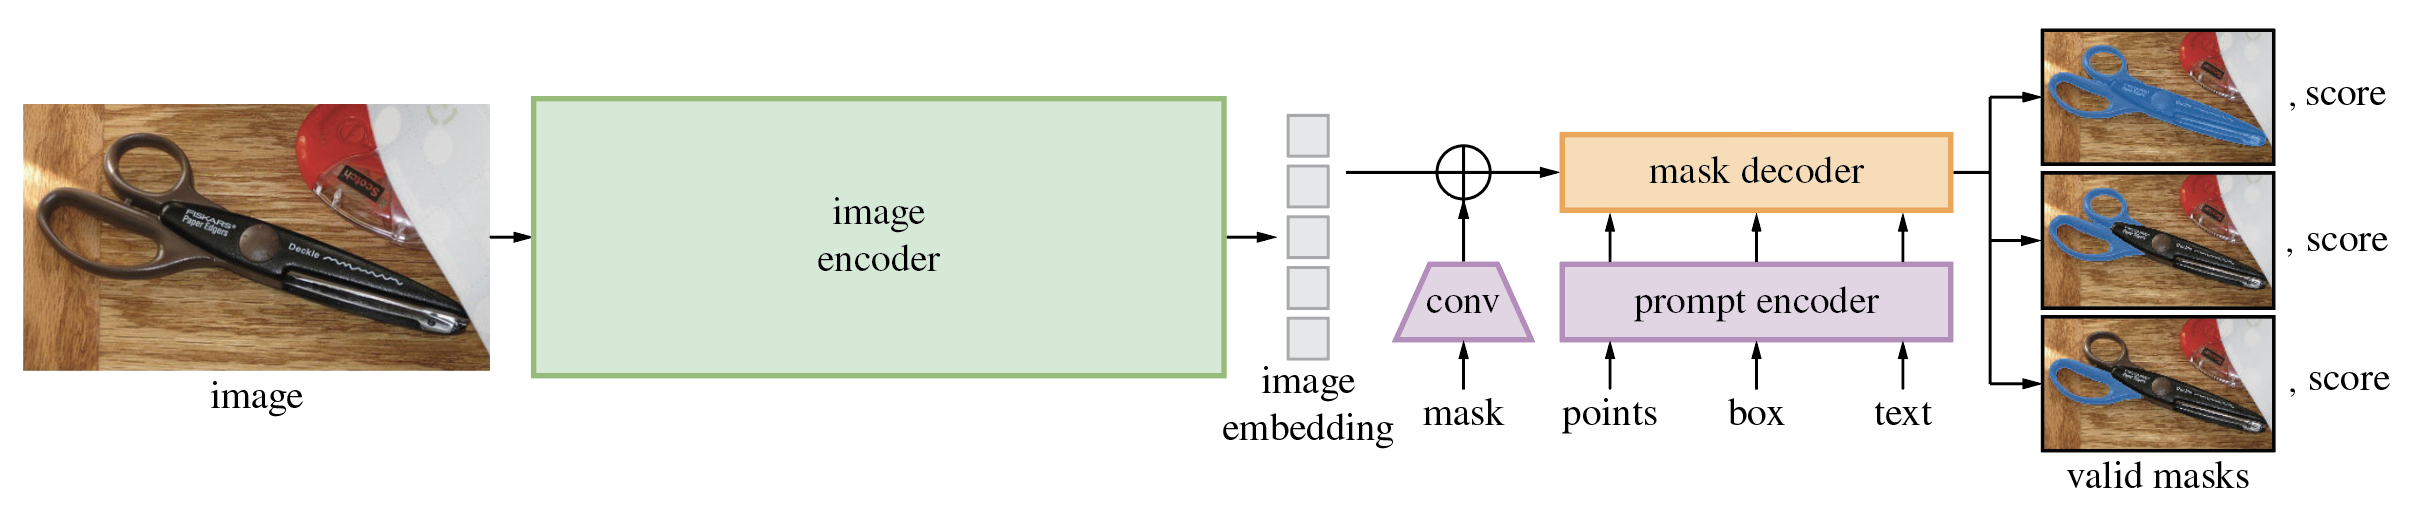

**Set-up enviroment**

To run this colab you will need to import some python modules such as opencv and install SAM using the provided instructions [here](https://github.com/facebookresearch/segment-anything).

First we will install SAM and download its pre-trained weights. These latter will be used to load the model from a checkpoint in order to generate segmentation masks for all objects in the provided image(s).

In [1]:
!pip install 'git+https://github.com/facebookresearch/segment-anything.git'

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-svjo3n23
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-svjo3n23
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36586 sha256=224976072de6c12d9091dee115f1a1a2e85d70ff79db10ae62d4df577356232a
  Stored in directory: /tmp/pip-ephem-wheel-cache-qseptp4c/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything


In [2]:
from google.colab import files
import torch
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
import matplotlib.pyplot as plt
import random
import numpy as np
import os
import cv2

In [3]:
!mkdir weights
%cd weights
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
%cd ../

/content/weights
/content



**Help-in functions**

*This function will load the images to be segmented into a folder called* `images_to_be_segmented`.

In [17]:
def load_test_data():
    uploaded = files.upload()
    filename = next(iter(uploaded)) #Naima : get the filename of the uploaded file
    try:
      if ('.zip' in filename):
            !unzip *.zip -d images_to_be_segmented
            os.remove(filename) #Naima: remove the ".zip" file from the server after it has been extracted.
            return [1, './images_to_be_segmented/'] #Naima: return the type of the uploaded file (0 if ".jpg", 1 if ".zip") as well the folder path.
      elif ('.jpg' in filename):
            return [0, filename]
      else :
        raise ValueError('Error! please provide a \".zip\" or \".jpg\" file') #Naima: raises an error if the file type is different from ".zip" or ".jpg".
    except ValueError as e:
      print(e)
      os.remove(filename)
      return [-1, ""]

*This function will return the list of images to be segmented.*



```
path: is the path of the folder that holders all the images to be segmented.
testImagesList: represents the list of all the images to be segmented.

```



In [5]:
def get_the_list_of_test_images(path, testImagesList = []):
  for f in os.listdir(path):
    subFolderPath = os.path.join(path, f)
    if(os.path.isfile(subFolderPath)):
       if('.jpg' in subFolderPath): #Naima: this ensure keeping only ".jpg" files in case the user uploaded a ".zip" file (we can't guess the content).
          testImagesList.append(subFolderPath)
    if(os.path.isdir(subFolderPath)):
      get_the_list_of_test_images(subFolderPath, testImagesList) #Naima: use recursion to get the list of all images in all sub-folders.
  return testImagesList

*This function will read and process the image(s) to be segmented using openCV.*


```
testImagesList: represent the list of all the images to be segmented.
isFolder: indicates whether you provided one image at a time or a number of images.
```



In [6]:
def read_and_preprocess_image(testImagesList, isFolder):
  if(isFolder == 0): #Naima: if one image is provided at a time
    img = cv2.imread(testImagesList) #Naima: read the current image from the provided file path
    imageRgb = cv2.cvtColor(img,cv2.COLOR_BGR2RGB) #Naima: convert it to RGB
    return imageRgb
  else :
    imagesRgb = []
    for filename in testImagesList :
      print(filename)
      image = cv2.imread(filename)
      imageRgb = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
      imagesRgb.append(imageRgb) #Naima: collect all RGB images into a list to provide it to SAM later on
    return imagesRgb

*This function will display some random images from the images to be segmented. In case you choose to provide one image at a time, this function will only display the current image.*

```
imagesRgb: is the list of all the images to be segmented.
isFolder: indicates whether you provided one image at a time or a number of images.
```
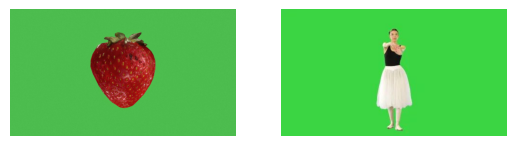

In [7]:
def display_some_images(imagesRgb, isFolder):
      if(isFolder == 0): #Naima: if one image is provided at a time
          plt.axis('off') #Naima: turn off axis labeling
          plt.imshow(imagesRgb) # Naima: use matplotlib to display the provided image
      else : #Naima: if a number of images were provided
        fig, axs = plt.subplots(1,2)
        axs = axs.ravel()
        imagesRgbtemp = imagesRgb.copy()
        random.shuffle(imagesRgbtemp) # Naima: use matplotlib to display 2 random images from the set of images to be segmented
        for i in range(2):
          axs[i].axis('off')
          axs[i].imshow(imagesRgbtemp[i])

*This function will help you load SAM pretrained weights from the provided checkpoint. I highly recommend that you use the `GPU` runtime to run SAM inference.
For instance you can activate the* `GPU` *runtime by selecting* `Runtime -> Change runtime type -> T4 GPU`.

```
pathToSamWeights: gives the path to the folder where we downloaded SAM weights at the first place.
device: specify whether to use GPU or CPU to run inference with SAM.
```



In [8]:
def loadSamModel(device, pathToSamWeights = '/content/weights/sam_vit_h_4b8939.pth'):
  sam = sam_model_registry['vit_h'](checkpoint=pathToSamWeights).to(device=device)
  return sam

*This function uses SAM to generate all the segmentation masks for all the objects in the current image. It then sorts the generated masks by area to identify the segmentation mask that highlights the foreground (the object that has the highest Region Of Interest (ROI)).*


```
imageRgb: is the current RGB image to be segmented.
```

In [18]:
def Extract_background_foreground_with_sam(imageRgb):
    sam = loadSamModel(device) #Naima: load SAM pre-trained weights
    maskGenerator = SamAutomaticMaskGenerator(sam)
    sam_result = maskGenerator.generate(imageRgb) #Naima: automatically generate segmentation masks for all object in the image
    masks = [
    mask['segmentation']
    for mask
    in sorted(sam_result, key=lambda x: x['area'], reverse=True)
    ] #Naima: sort the generated segmentation masks by area
    mask= masks[0] #Naima: get the foreground and background masks
    return mask

*This function will save the binary masks as `.jpg` in the same folder as the original image.*

*P.S: a subfolder called masks is created under the current image folder to hold the binary masks of all the images in that folder.*

```
mask: is the foreground mask for the current image.
imageRgbFilename: represent the filepath to the current image to be segmented.  
```

In [10]:
def save_binary_mask(imageRgbFilename, mask):
    mask = (mask * 255).astype(np.uint8)  # Naima : convert mask to uint8 format
    mask =255-mask
    folder_name = '/'.join(imageRgbFilename.split('/')[0:-1])
    maskFilename = (imageRgbFilename.split('.jpg')[0]).split("/")[-1] + '.jpg'
    if not os.path.exists('/content/' + folder_name + '/masks/'): #Naima: create folder if does'nt exist
      os.makedirs('/content/' + folder_name + '/masks/')
    cv2.imwrite('/content/' + folder_name + '/masks/' + maskFilename, mask)

*This function will display the generated binary mask for a given image.*

```
imageRgbFilename: is the path to the given image.
```
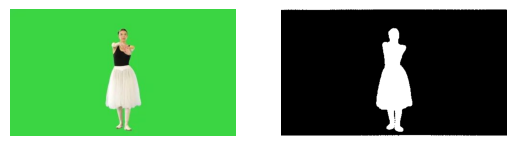

In [11]:
def display_binary_mask(imageRgbFilename):
    folder_name = '/'.join(imageRgbFilename.split('/')[0:-1])
    maskFilename = folder_name + '/masks/' + (imageRgbFilename.split('.jpg')[0]).split("/")[-1] + '.jpg'
    print(maskFilename)
    image = cv2.imread(imageRgbFilename)
    imagergb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(maskFilename)
    ax1 =plt.subplot(121)
    ax1.axis('off')
    ax1.imshow(imagergb)
    ax2 =plt.subplot(122)
    ax2.axis('off')
    ax2.imshow(mask)

**Load the images to be segmented**

In order to run the foreground and background extraction on your image(s) with green background you will need to provide some images as a `.zip` file or one image at a time. Be careful, you should use `.jpg` file in case you would like to provide one image at a time!

In [12]:
isFolder = -1
while(isFolder == -1):
  isFolder, Filepath = load_test_data()
testImagesList = []
if(isFolder == 1):
  testImagesList = get_the_list_of_test_images(Filepath)
else :
  testImagesList = Filepath

Saving images_with_green_screen.zip to images_with_green_screen.zip
Archive:  images_with_green_screen.zip
   creating: images_to_be_segmented/images_with_green_screen/animals/
  inflating: images_to_be_segmented/images_with_green_screen/animals/animal2.jpg  
  inflating: images_to_be_segmented/images_with_green_screen/animals/animal3.jpg  
   creating: images_to_be_segmented/images_with_green_screen/fruits/
  inflating: images_to_be_segmented/images_with_green_screen/fruits/fruit1.jpg  
   creating: images_to_be_segmented/images_with_green_screen/persons/
  inflating: images_to_be_segmented/images_with_green_screen/persons/person2.jpg  


Now it's time to generate the binary mask(s) for the provided image(s) using SAM.

First you will need to read the image(s) to be segmented and display some random examples.

./images_to_be_segmented/images_with_green_screen/fruits/fruit1.jpg
./images_to_be_segmented/images_with_green_screen/persons/person2.jpg
./images_to_be_segmented/images_with_green_screen/animals/animal2.jpg
./images_to_be_segmented/images_with_green_screen/animals/animal3.jpg


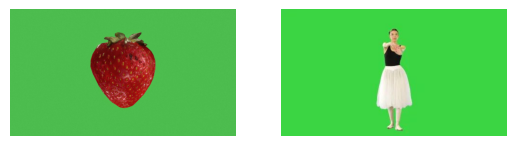

In [13]:
imagesRgb = read_and_preprocess_image(testImagesList, isFolder)
display_some_images(imagesRgb, isFolder)

Then, you will run SAM to generate the binary mask(s), highlighting the foreground and the background for the provided image(s).

In [14]:
if torch.cuda.is_available(): #Naima: check whether GPU is available to be used during inference
  device = torch.device('cuda:0')
else:
  device = torch.device('cpu')

In [19]:
if(isFolder == 1):
  for i, imageRgb in enumerate(imagesRgb):
    print('Generating binary mask for:', testImagesList[i])
    print('...')
    mask = Extract_background_foreground_with_sam(imagesRgb[i])
    save_binary_mask(testImagesList[i], mask)
else :
    print('Generating binary mask for:', testImagesList)
    print('...')
    mask = Extract_background_foreground_with_sam(imagesRgb)
    save_binary_mask(testImagesList, mask)

Generating binary mask for: ./images_to_be_segmented/images_with_green_screen/fruits/fruit1.jpg
...
Generating binary mask for: ./images_to_be_segmented/images_with_green_screen/persons/person2.jpg
...
Generating binary mask for: ./images_to_be_segmented/images_with_green_screen/animals/animal2.jpg
...
Generating binary mask for: ./images_to_be_segmented/images_with_green_screen/animals/animal3.jpg
...


/content/images_to_be_segmented/images_with_green_screen/persons/masks/person2.jpg


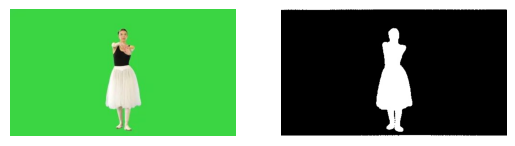

In [23]:
imgFileName = '/content/images_to_be_segmented/images_with_green_screen/persons/person2.jpg' #Naima: you should change this line of code with the path of the desired image
display_binary_mask(imgFileName)

Finally, you will download the binary mask(s) as well as the original image(s) as `.zip`file.




In [24]:
try:
  if(isFolder == 1):
    !zip -r images_to_be_segmented.zip images_to_be_segmented/
    files.download('images_to_be_segmented.zip')
  else :
    raise ValueError('Please download the binary mask using the file manager panel')
except ValueError as e:
  print(e)

  adding: images_to_be_segmented/ (stored 0%)
  adding: images_to_be_segmented/images_with_green_screen/ (stored 0%)
  adding: images_to_be_segmented/images_with_green_screen/fruits/ (stored 0%)
  adding: images_to_be_segmented/images_with_green_screen/fruits/masks/ (stored 0%)
  adding: images_to_be_segmented/images_with_green_screen/fruits/masks/fruit1.jpg (deflated 56%)
  adding: images_to_be_segmented/images_with_green_screen/fruits/fruit1.jpg (deflated 0%)
  adding: images_to_be_segmented/images_with_green_screen/persons/ (stored 0%)
  adding: images_to_be_segmented/images_with_green_screen/persons/masks/ (stored 0%)
  adding: images_to_be_segmented/images_with_green_screen/persons/masks/person2.jpg (deflated 22%)
  adding: images_to_be_segmented/images_with_green_screen/persons/person2.jpg (deflated 17%)
  adding: images_to_be_segmented/images_with_green_screen/animals/ (stored 0%)
  adding: images_to_be_segmented/images_with_green_screen/animals/masks/ (stored 0%)
  adding: imag

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

License for this notebook belong to Naima ZOUIDI

CC-BY-NC-ND (naima.zouidi@insa-rennes.fr)